# Pipedrive CRM Data Exploration

This notebook contains the exploratory analysis that informed the design of the dbt models.

## Objectives
1. Connect to the Postgres database.
2. Identify data quality issues (duplicates).
3. Analyze deal loss reasons.
4. Visualize the sales funnel.

In [1]:
import pandas as pd
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt

# Database Connection String
# Note: 'db' is the hostname of the postgres service in Docker
DB_CONNECTION = "postgresql://admin:admin@db:5432/postgres"
engine = sqlalchemy.create_engine(DB_CONNECTION)

print("Connected to database!")

Connected to database!


## 1. Duplicate Analysis: Deal Creation Events

We noticed that some deals have multiple 'add_time' events in the `deal_changes` table. Let's quantify this.

In [2]:
query_duplicates = """
SELECT 
    deal_id,
    COUNT(*) as creation_events
FROM public.deal_changes
WHERE changed_field_key = 'add_time'
GROUP BY deal_id
HAVING COUNT(*) > 1
ORDER BY creation_events DESC
LIMIT 5;
"""

df_duplicates = pd.read_sql(query_duplicates, engine)
print(f"Sample of deals with multiple creation events:\n{df_duplicates}")

# Total duplicates
total_dupes = pd.read_sql(
    "SELECT COUNT(*) FROM (SELECT deal_id FROM public.deal_changes WHERE changed_field_key = 'add_time' GROUP BY deal_id HAVING COUNT(*) > 1) as sub", 
    engine
).iloc[0,0]

print(f"\nTotal deals with duplicate creation events: {total_dupes}")

Sample of deals with multiple creation events:
   deal_id  creation_events
0   851850               10
1   556338               10
2   399956               10
3   955417               10
4   554294               10

Total deals with duplicate creation events: 1995


**Finding**: There are exactlly 1,995 deals with duplicate creation events. 
**Decision**: In our dbt models (`int_deals`), we will handle this by taking the `MIN(changed_at)` as the true creation time.

## 2. Lost Reason Analysis

Analyzing why deals are lost is critical for the 'Lost' funnel step.

/tmp/ipykernel_138/1471882037.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_losses, x='count', y='reason_label', palette='viridis')


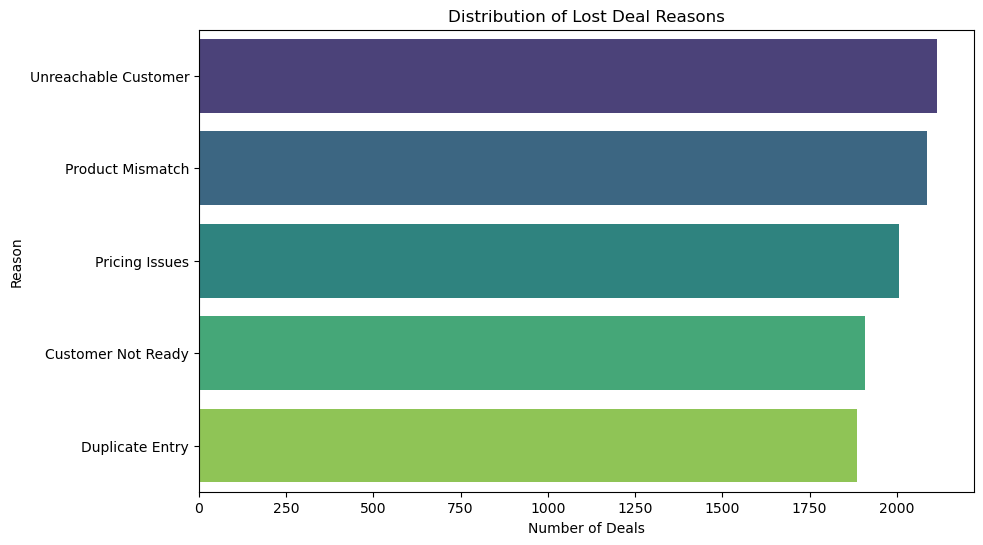

In [3]:
query_losses = """
SELECT 
    new_value as lost_reason_id,
    COUNT(*) as count
FROM public.deal_changes
WHERE changed_field_key = 'lost_reason'
GROUP BY new_value
ORDER BY count DESC;
"""

df_losses = pd.read_sql(query_losses, engine)

# Map IDs to labels (based on knowledge from 'fields' table)
loss_map = {
    '1': 'Customer Not Ready',
    '2': 'Pricing Issues',
    '3': 'Unreachable Customer',
    '4': 'Product Mismatch',
    '5': 'Duplicate Entry'
}
df_losses['reason_label'] = df_losses['lost_reason_id'].map(loss_map)

plt.figure(figsize=(10,6))
sns.barplot(data=df_losses, x='count', y='reason_label', palette='viridis')
plt.title('Distribution of Lost Deal Reasons')
plt.xlabel('Number of Deals')
plt.ylabel('Reason')
plt.show()

## 3. Funnel Visualization (Preview)

Let's look at the final data from our Marts layer to verify the funnel shape.

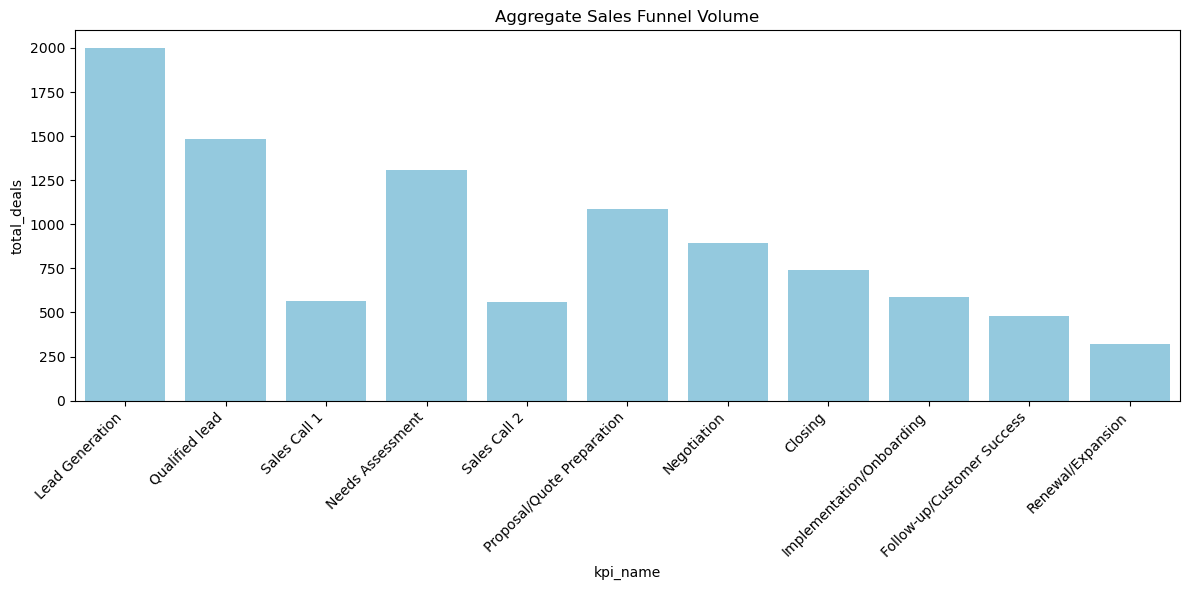

In [4]:
query_funnel = """
SELECT 
    funnel_step,
    kpi_name,
    SUM(deals_count) as total_deals
FROM public_marts.rep_sales_funnel_monthly
WHERE funnel_step != 'Lost'
GROUP BY funnel_step, kpi_name
ORDER BY funnel_step;
"""

try:
    df_funnel = pd.read_sql(query_funnel, engine)
    
    plt.figure(figsize=(12,6))
    sns.barplot(data=df_funnel, x='kpi_name', y='total_deals', color='skyblue')
    plt.title('Aggregate Sales Funnel Volume')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Marts table not found. Run 'dbt run' first!")
    print(e)